Important:
* Causal insights: Understanding which factors significantly impact wheat prices (e.g., diesel prices, rainfall, CPI, etc.)

* Forecasting model: Predicting future Wheat Prices based on these variables.

###Game Plan for Your Wheat Price Analysis
#### Step 1: Data Preparation
* Handle missing values

* Ensure all date fields are in datetime format

* Check for multicollinearity (e.g., Date and Year might be redundant)

* Normalize/standardize continuous features (for forecasting models like SVR or LSTM)

#### Step 2: Exploratory Data Analysis (EDA)
* Visualize trends over time:

* Wheat prices vs time

* Diesel/Wheat ratio vs Wheat Price

* Correlation heatmap

* Seasonal patterns in Wheat prices (monthly or quarterly)



Step 3: Causal Understanding
Use a linear regression or tree-based model (like RandomForest) to understand feature importance:

Option A: Linear Regression (for interpretability)

In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv('/content/wheat_prices_merged.csv')

Indexing by Date and month within Date for timeseries data

In [ ]:
# Ensure 'Date' column is in datetime format
df['Date'] = pd.to_datetime(df['date'], errors='coerce')  # Convert 'Date' to datetime

# Step 2: Sort by 'Date'
df = df.sort_values(by='Date')

# Step 3: Set 'Date' as the index (drop the 'Date' column)
df = df.set_index('Date', drop=True)
df = df.drop(columns=['date'])
# Verify the result
print(df.head())


                     state            category commodity pricetype currency  \
Date                                                                          
1994-01-15           delhi  cereals and tubers     Wheat    Retail      INR   
1994-01-15         gujarat  cereals and tubers     Wheat    Retail      INR   
1994-01-15       karnataka  cereals and tubers     Wheat    Retail      INR   
1994-01-15  madhya pradesh  cereals and tubers     Wheat    Retail      INR   
1994-01-15     maharashtra  cereals and tubers     Wheat    Retail      INR   

            year  price    CPI month  msp_year  ...  \
Date                                            ...   
1994-01-15  1994    5.0  10.25   jan      1993  ...   
1994-01-15  1994    6.2  10.25   jan      1993  ...   
1994-01-15  1994    7.0  10.25   jan      1993  ...   
1994-01-15  1994    4.5  10.25   jan      1993  ...   
1994-01-15  1994    8.0  10.25   jan      1993  ...   

           Diesel / Wheat Price Ratio      date_x Rainfall  

Basic Cleanup
* Drop irrelevant columns, Fix Duplicate Date column, Convert date to proper format, Fix numeric conversions for ROC columns

In [ ]:
# Drop unnecessary columns
df = df.drop(columns=[col for col in ['index', '0'] if col in df.columns])

# Convert ROC columns to numeric if they are object
df['Diesel ROC'] = pd.to_numeric(df['Diesel ROC'], errors='coerce')
df['Wheat ROC'] = pd.to_numeric(df['Wheat ROC'], errors='coerce')

# Check for missing values
df.isnull().sum().sort_values(ascending=False).head(10)

,0
JF,2461
JJAS,2461
OND,2461
ANNUAL,2461
Rainfall,2461
MAM,2461
Diesel ROC,1551
Wheat ROC,1551
Wheat Price (Indian Rupee per Metric Ton),1537
Diesel / Wheat Price Ratio,1537


Handling Missing Values (Rainfall, Diesel Price, Derived Columns)


* Fill missing rainfall data using average per state and year - Rainfall is indeed seasonal and location-dependent, so imputing missing values by (state, month) can yield more accurate estimates, especiallywhen working with time series data across multiple years.

* Fill missing diesel prices with forward/backward fill by state - wanting to look at prices based on previous years and need to do indexing, the data must be sorted chronologically within each state to ensure that forward/backward fills and percent changes (like Diesel ROC) are meaningful.

* Recalculate Diesel ROC, Wheat ROC, and the Diesel / Wheat Price Ratio

* Fill in derived columns



In [ ]:
# Define the rainfall-related columns to impute
rainfall_cols = ['Rainfall', 'ANNUAL', 'JF', 'MAM', 'JJAS', 'OND']

# Loop through each column and fill missing values based on (state, month)
for col in rainfall_cols:
    if col in df.columns:
        df[col] = df.groupby(['state', 'month'])[col].transform(lambda x: x.fillna(x.mean()))


In [ ]:


# Fill missing Diesel Prices using ffill + bfill within each state
df['Diesel Price'] = df.groupby('state')['Diesel Price'].transform(lambda x: x.ffill().bfill())

# Calculate Diesel ROC (Rate of Change) within each state
df['Diesel ROC'] = df.groupby('state')['Diesel Price'].pct_change() * 100

# Fill missing Diesel ROC values with 0 (first row in each group will have NaN)
df['Diesel ROC'] = df['Diesel ROC'].fillna(0)

# Calculate Wheat ROC (Rate of Change) within each state
df['Wheat ROC'] = df.groupby('state')['price'].pct_change() * 100

# Fill missing Wheat ROC values with 0
df['Wheat ROC'] = df['Wheat ROC'].fillna(0)

# Recalculate Diesel/Wheat Price Ratio
df['Diesel / Wheat Price Ratio'] = df['Diesel Price'] / df['price']

# Fill missing Diesel/Wheat Price Ratio values with the mean of the column
df['Diesel / Wheat Price Ratio'] = df['Diesel / Wheat Price Ratio'].fillna(df['Diesel / Wheat Price Ratio'].mean())

# Final check: Display top 10 columns with the highest number of missing values
df.isnull().sum().sort_values(ascending=False).head(10)


,0
Wheat Price (Indian Rupee per Metric Ton),1537
JJAS,1322
Rainfall,1322
ANNUAL,1322
JF,1322
MAM,1322
OND,1322
category,0
state,0
month,0


Rainfall data (JJAS, OND, ANNUAL, MAM, JF, Rainfall) → Still missing in 1322 rows.

Even after state + month average filling, those values were entirely missing in many groupings.

Wheat Price correspond to diesel price (Indian Rupee per Metric Ton) → Still missing in 1,537 rows.

We can likely replace this with the available price column.

*   Fallback fill rainfall columns using only state averages

* Fill Wheat Price (Metric Ton) using price

In [ ]:
# Fill missing Rainfall data using state + month average
rainfall_cols = ['Rainfall', 'ANNUAL', 'JF', 'MAM', 'JJAS', 'OND']
for col in rainfall_cols:
    if col in df.columns:
        df[col] = df.groupby(['state', 'month'])[col].transform(lambda x: x.fillna(x.mean()))

# Fallback: Fill remaining missing Rainfall values using state average
for col in rainfall_cols:
    if col in df.columns:
        df[col] = df.groupby('state')[col].transform(lambda x: x.fillna(x.mean()))

# Fill missing Wheat Price using 'price' column (assuming 'price' can be used as a proxy for Wheat Price)
df['Wheat Price (Indian Rupee per Metric Ton)'] = df['Wheat Price (Indian Rupee per Metric Ton)'].fillna(df['price'])

# Verify if missing values were filled
df.isnull().sum().sort_values(ascending=False).head(10)



,0
JF,1319
JJAS,1319
OND,1319
ANNUAL,1319
Rainfall,1319
MAM,1319
commodity,0
category,0
state,0
month,0


All price-related, CPI, MSP, and diesel data is now clean

Only rainfall and seasonal rainfall columns still have missing values — 1,319 rows (~23% of data)

These are likely states with no rainfall data ever reported

In [ ]:
# Fill rainfall columns using national (global) mean
for col in rainfall_cols:
    df[col] = df[col].fillna(df[col].mean())

# Final confirmation
df.isnull().sum().sort_values(ascending=False)

,0
state,0
category,0
commodity,0
pricetype,0
currency,0
year,0
price,0
CPI,0
month,0
msp_year,0


Importing required Libraries

In [ ]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split
import xgboost as xgb  # This line should work correctly now

### Exploratory Data Analysis
Plotting Wheat Price Over Time

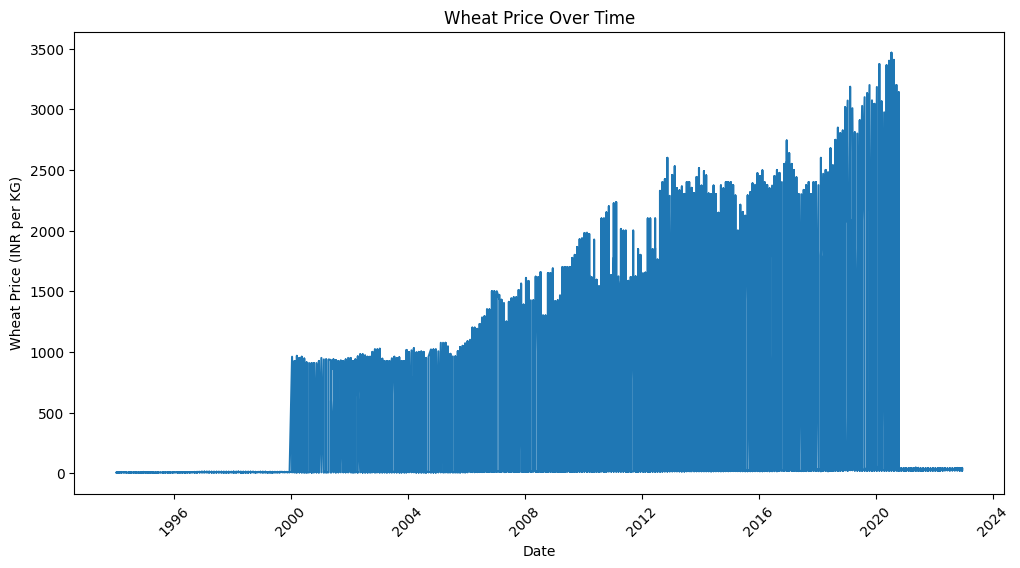

In [ ]:
import matplotlib.pyplot as plt

# Plotting the wheat price over time (using Date as the index)
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['price'])  # Use df.index since 'Date' is the index
plt.title('Wheat Price Over Time')
plt.xlabel('Date')
plt.ylabel('Wheat Price (INR per KG)')
plt.xticks(rotation=45)
plt.show()


Create Lag features and Rolling Averages

* Creating lag features and rolling averages  in time series analysis and machine learning to capture patterns over time
* Rolling averages smooth out short-term fluctuations and highlight longer-term trends or cycles
   * Reduces noise

   * Detects trends .

   * Smoothed version of the signal can be a good predictor.

In [ ]:
# Lag features
df['Price Lag 1'] = df['price'].shift(1)
df['Price Lag 3'] = df['price'].shift(3)
df['Price Lag 6'] = df['price'].shift(6)
df['Price Lag 12'] = df['price'].shift(12)

df['Diesel Price Lag 1'] = df['Diesel Price'].shift(1)
df['Diesel Price Lag 3'] = df['Diesel Price'].shift(3)
df['Diesel Price Lag 6'] = df['Diesel Price'].shift(6)
df['Diesel Price Lag 12'] = df['Diesel Price'].shift(12)

df['CPI Lag 1'] = df['CPI'].shift(1)
df['CPI Lag 3'] = df['CPI'].shift(3)
df['CPI Lag 6'] = df['CPI'].shift(6)
df['CPI Lag 12'] = df['CPI'].shift(12)

# Rolling averages
df['Price Rolling Mean 3'] = df['price'].rolling(window=3).mean()
df['Price Rolling Mean 6'] = df['price'].rolling(window=6).mean()
df['Diesel Price Rolling Mean 3'] = df['Diesel Price'].rolling(window=3).mean()
df['Diesel Price Rolling Mean 6'] = df['Diesel Price'].rolling(window=6).mean()

# Rolling standard deviation
df['Price Rolling Std 3'] = df['price'].rolling(window=3).std()
df['Diesel Price Rolling Std 3'] = df['Diesel Price'].rolling(window=3).std()

# Rate of Change (month-over-month)
df['Price ROC 1'] = df['price'].pct_change(periods=1)
df['Price ROC 3'] = df['price'].pct_change(periods=3)
df['Diesel Price ROC 1'] = df['Diesel Price'].pct_change(periods=1)
df['Diesel Price ROC 3'] = df['Diesel Price'].pct_change(periods=3)

# COVID period feature
df['covid_period'] = df.index.to_series().between("2020-03-01", "2021-12-31").astype(int)

# Remove rows with NaNs from lags/rollings
df = df.dropna()

# Display the dataframe with new features from lag, rolling, and other calculations
print(df.head())


                    state            category commodity pricetype currency  \
Date                                                                         
1994-03-15      telangana  cereals and tubers     Wheat    Retail      INR   
1994-03-15      rajasthan  cereals and tubers     Wheat    Retail      INR   
1994-03-15      meghalaya  cereals and tubers     Wheat    Retail      INR   
1994-03-15    maharashtra  cereals and tubers     Wheat    Retail      INR   
1994-03-15  uttar pradesh  cereals and tubers     Wheat    Retail      INR   

            year  price    CPI month  msp_year  ... Price Rolling Mean 6  \
Date                                            ...                        
1994-03-15  1994   7.00  10.25   mar      1994  ...             5.975000   
1994-03-15  1994   4.80  10.25   mar      1994  ...             5.775000   
1994-03-15  1994   5.00  10.25   mar      1994  ...             5.841667   
1994-03-15  1994   8.00  10.25   mar      1994  ...             5.841667 

For the NaN values that appear after shifting (Price Lag 1, Diesel Price Lag 1, CPI Lag 1), you can handle them in a few ways:

Drop rows with NaN values: This will remove the rows that have missing lag or rolling values.

Fill NaN values with a specific value (e.g., the mean, median, or 0). However, this is less common for lag and rolling features since it could distort the time series relationships.

Forward fill or backward fill: This can propagate the next or previous values into the missing spots.

Explanation:
groupby(['state', 'month']): This groups the data by state and month.

.apply(lambda group: group.ffill()): This applies forward filling (ffill()) within each group of state and month.

This ensures that the missing values are filled using the most recent available value from the same state and month group.

In [ ]:

# Forward fill NaNs within each state-month group (no MultiIndex)
data_filled_grouped = (
    df.groupby(['state', 'month'], group_keys=False)
      .apply(lambda group: group.sort_index().ffill())
)

# Confirm result
print(data_filled_grouped.head())


                  state            category commodity pricetype currency  \
Date                                                                       
1994-03-15        delhi  cereals and tubers     Wheat    Retail      INR   
1994-03-15      gujarat  cereals and tubers     Wheat    Retail      INR   
1994-03-15    karnataka  cereals and tubers     Wheat    Retail      INR   
1994-03-15       kerala  cereals and tubers     Wheat    Retail      INR   
1994-03-15  maharashtra  cereals and tubers     Wheat    Retail      INR   

            year  price    CPI month  msp_year  ... Price Rolling Mean 6  \
Date                                            ...                        
1994-03-15  1994    5.0  10.25   mar      1994  ...             6.041667   
1994-03-15  1994    6.5  10.25   mar      1994  ...             6.008333   
1994-03-15  1994    6.5  10.25   mar      1994  ...             6.091667   
1994-03-15  1994   10.0  10.25   mar      1994  ...             6.875000   
1994-03-15 

<ipython-input-63-6bb2bf0a85ca>:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: group.sort_index().ffill())


Seasonal Decomposition

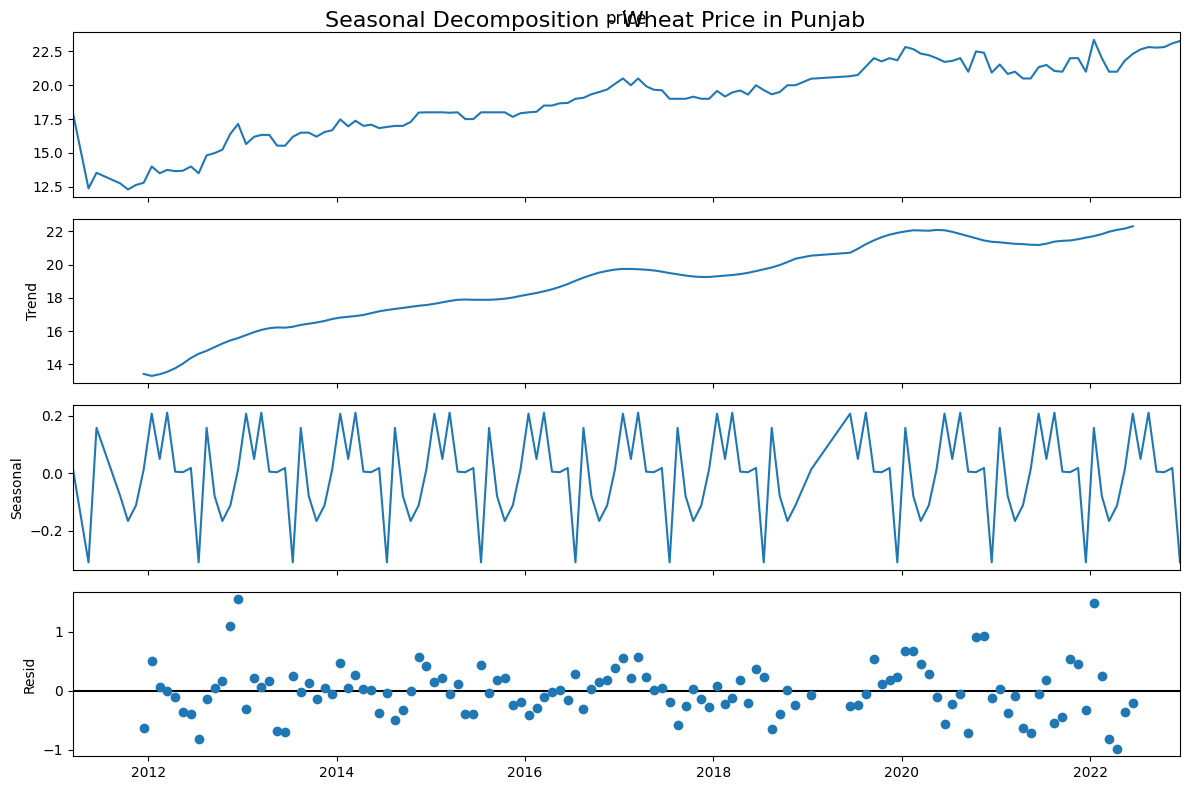

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

# Pick a sample state to analyze (or loop later)
sample_state = 'punjab'
state_data = df[df['state'] == sample_state].copy()
state_data = state_data.sort_values(by='Date')

# Decompose the price (monthly frequency assumed)
decomposition = seasonal_decompose(state_data['price'], model='additive', period=12)

# Plot decomposition
plt.rcParams.update({'figure.figsize': (12, 8)})
decomposition.plot()
plt.suptitle(f'Seasonal Decomposition - Wheat Price in {sample_state.title()}', fontsize=16)
plt.show()

Trend and seasonality are visually the same in both additive and multiplicative models and only residuals differ slightly, it means either can technically work, but we’ll pick the one that suits the data's scale and variance pattern best

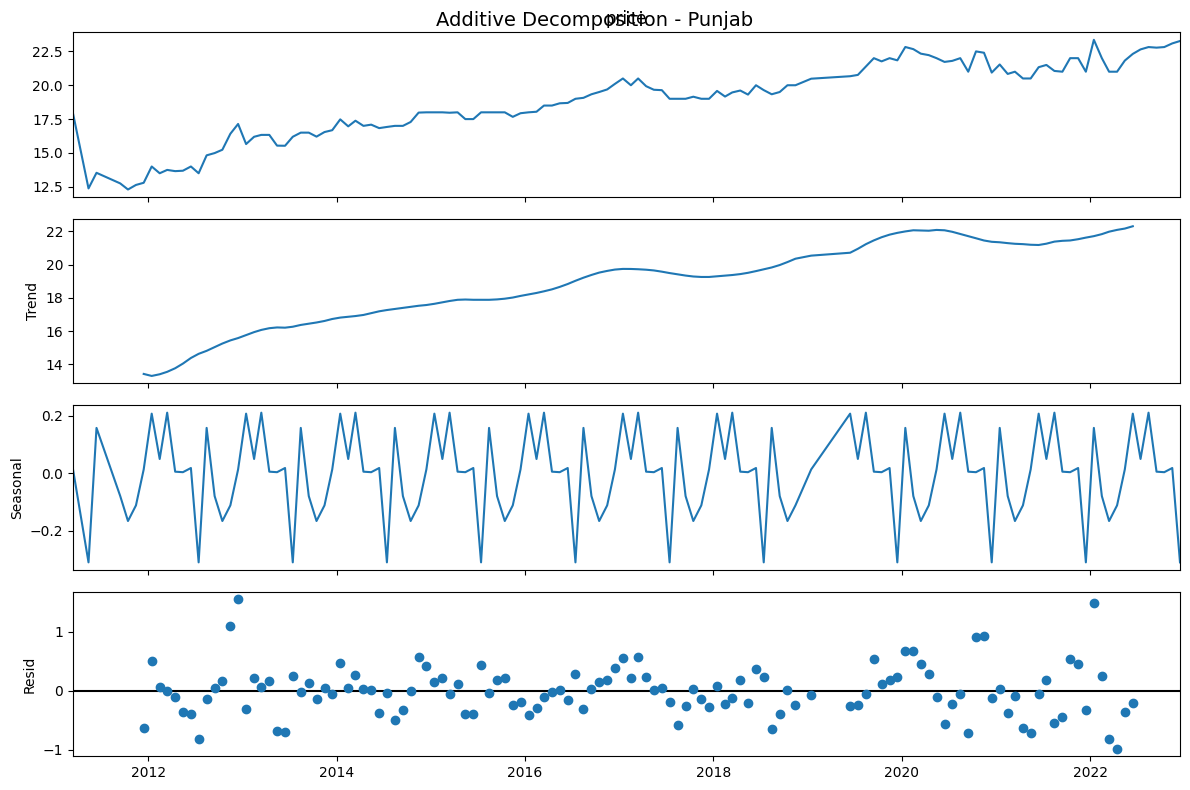

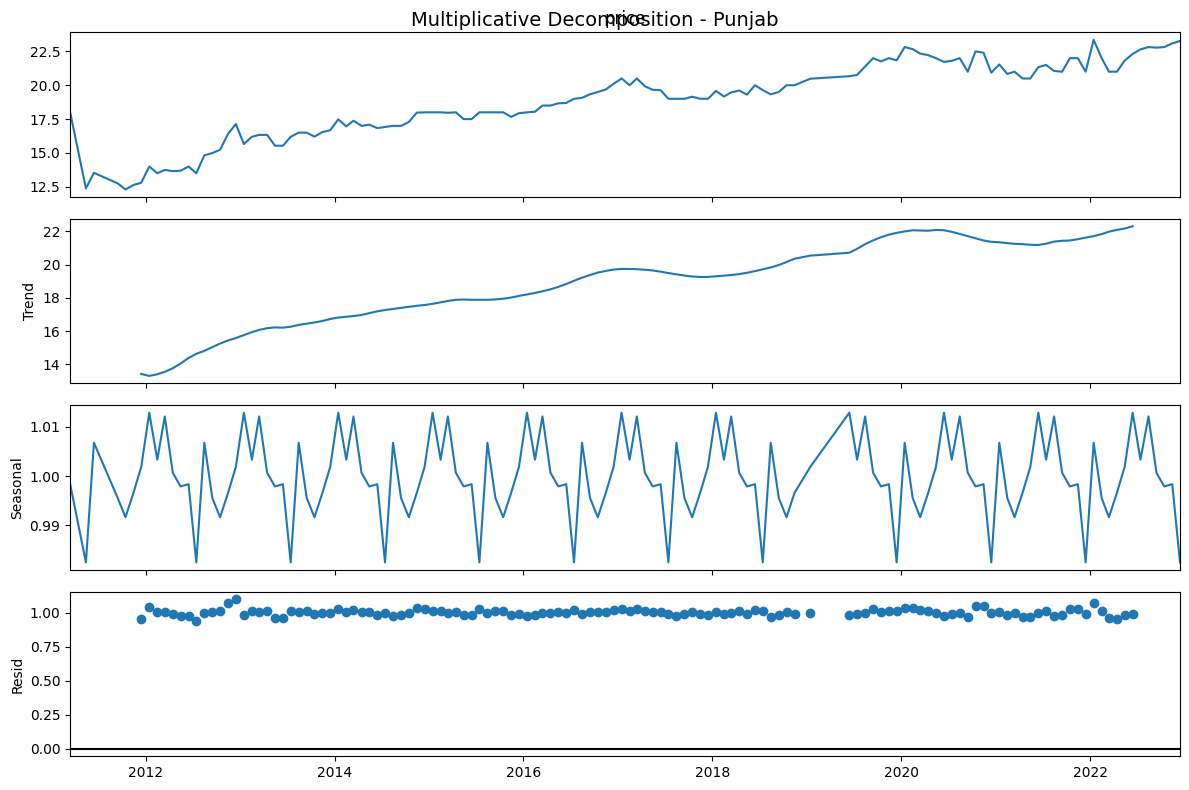

In [ ]:



# Additive decomposition
additive = seasonal_decompose(state_data['price'], model='additive', period=12)
additive.plot()
plt.suptitle(f'Additive Decomposition - {sample_state.title()}', fontsize=14)
plt.show()

# Multiplicative decomposition
multiplicative = seasonal_decompose(state_data['price'], model='multiplicative', period=12)
multiplicative.plot()
plt.suptitle(f'Multiplicative Decomposition - {sample_state.title()}', fontsize=14)
plt.show()




Here's how to decide
* Use Additive if:
The size of the seasonal component doesn’t change with the price level

Residuals are more stable (less spread)

* Use Multiplicative if:
Seasonality grows or shrinks with overall price level

Residuals look more "white noise" and less patterned

Since  the residuals differ, but trend and seasonal components are nearly the same, the residuals' behavior is the tiebreaker.

**So, checking the residual plot:**

*   If additive residuals are flatter and random → use Additive

* If multiplicative residuals are less patterned → use Multiplicative

Looking at the plot that straight-line-ish pattern in the multiplicative residuals at y=1 suggests the residuals may be less informative (or the model is over-simplifying). In contrast, the additive residuals, though slightly patterned, are more randomly distributed around 0, which is what we want.

Trend overtime by State

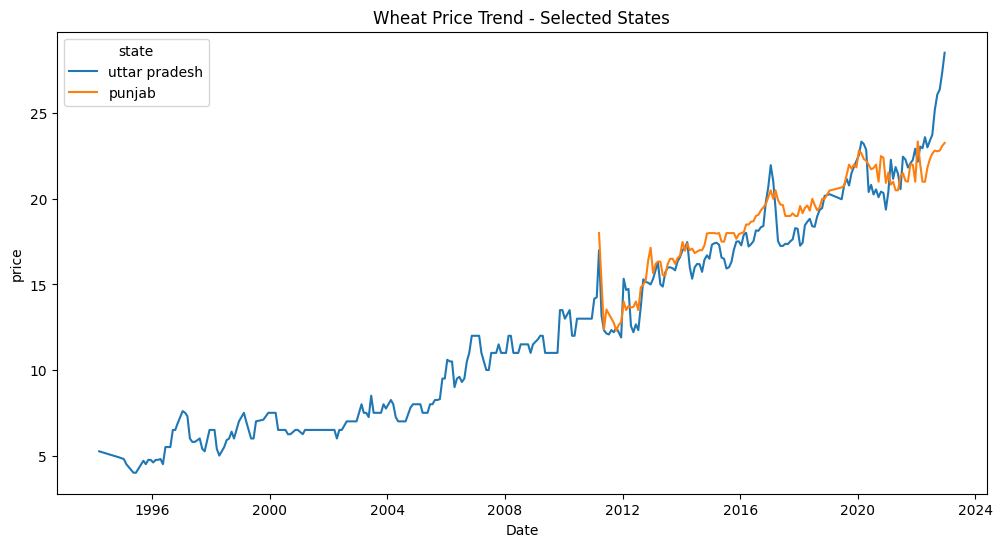

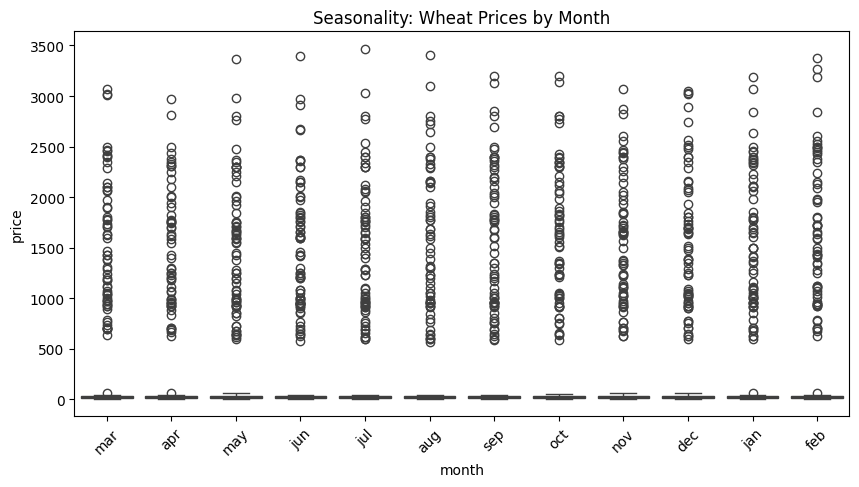

In [ ]:
# Trend over time by state (sample)
plt.figure(figsize=(12,6))
sns.lineplot(data=df[df['state'].isin(['punjab', 'uttar pradesh'])],
             x='Date', y='price', hue='state')
plt.title('Wheat Price Trend - Selected States')
plt.show()

# Seasonal plot by month
plt.figure(figsize=(10,5))
sns.boxplot(x='month', y='price', data=df)
plt.title('Seasonality: Wheat Prices by Month')
plt.xticks(rotation=45)
plt.show()

MSP Wheat price is in quintals, convert to KGs

In [ ]:
df['MSP_Wheat_KG'] = df['MSP_Wheat'] * 0.1

<ipython-input-69-abcd74949c16>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['MSP_Wheat_KG'] = df['MSP_Wheat'] * 0.1


Model Preparation Plan


1. Encode categorical variables:
One-hot or label encode state and month

2. Time-aware train-test split
Sorted by Date

Split each state's data separately (respect panel structure)

3. Train XGBoost
On combined panel (all states)

Predict next month’s price

Encode State and Month

In [ ]:
# Split the data (80% train, 20% test per state)
def time_split_panel(df, group_col, split_frac=0.8):
    train_list, test_list = [], []
    for key, group in df.groupby(group_col):
        group = group.sort_values('Date')  # Sorting the group by date to ensure proper time split
        split_idx = int(len(group) * split_frac)  # Calculate the split index
        train_list.append(group.iloc[:split_idx])  # Training data
        test_list.append(group.iloc[split_idx:])  # Testing data
    return pd.concat(train_list), pd.concat(test_list)  # Concatenate all groups for train and test sets

train_df, test_df = time_split_panel(df, 'state', split_frac=0.8)

# Apply One-Hot Encoding to the 'state' column for both train and test sets
train_df_encoded = pd.get_dummies(train_df, columns=['state'], drop_first=True)
test_df_encoded = pd.get_dummies(test_df, columns=['state'], drop_first=True)

# Align the columns (in case of new categories in the test set)
train_columns = train_df_encoded.columns
test_columns = test_df_encoded.columns

# Add missing columns in the test set (and set their values to 0)
missing_cols = set(train_columns) - set(test_columns)
for col in missing_cols:
    test_df_encoded[col] = 0

# Add missing columns in the train set (if any) and set to 0
missing_cols = set(test_columns) - set(train_columns)
for col in missing_cols:
    train_df_encoded[col] = 0

# Reorder the columns to match between train and test sets
test_df_encoded = test_df_encoded[train_columns]

# Display the encoded train and test data
print(train_df_encoded)
print(test_df_encoded)

                      category commodity pricetype currency  year  price  \
Date                                                                       
2012-07-15  cereals and tubers     Wheat    Retail      INR  2012  25.00   
2012-08-15  cereals and tubers     Wheat    Retail      INR  2012  25.00   
2012-09-15  cereals and tubers     Wheat    Retail      INR  2012  25.00   
2012-10-15  cereals and tubers     Wheat    Retail      INR  2012  25.32   
2012-11-15  cereals and tubers     Wheat    Retail      INR  2012  27.00   
...                        ...       ...       ...      ...   ...    ...   
2019-09-15  cereals and tubers     Wheat    Retail      INR  2019  24.59   
2019-10-15  cereals and tubers     Wheat    Retail      INR  2019  24.94   
2019-12-15  cereals and tubers     Wheat    Retail      INR  2019  25.00   
2020-01-15  cereals and tubers     Wheat    Retail      INR  2020  25.00   
2020-02-15  cereals and tubers     Wheat    Retail      INR  2020  25.21   

           

Train-Aware Train-Test Split by Panel (State)

The data model will train on all the states at once. When  the entire X_train (with all states) is passed to the model, it will use the encoded state_encoded variable to capture how the model associates each state with the target variable (price).
In this case, it does not treat each state separately **but instead learns the patterns of all states simultaneously, as it is based on a generalized feature set (state_encoded included as one of the inputs).**

If to train the model state-by-state, we have to split the dataset based on states and train a separate model for each. However, training the model for all states at once, with the state encoded as a feature, will allow the model to learn across states and potentially generalize better if there are patterns that can be shared.

In [ ]:
# Define the feature variable
features = [
    # Lag features
    'Price Lag 1', 'Price Lag 3', 'Price Lag 6', 'Price Lag 12',
    'Diesel Price Lag 1', 'Diesel Price Lag 3', 'Diesel Price Lag 6', 'Diesel Price Lag 12',
    'CPI Lag 1', 'CPI Lag 3', 'CPI Lag 6', 'CPI Lag 12',

    # Rolling mean features
    'Price Rolling Mean 3', 'Price Rolling Mean 6',
    'Diesel Price Rolling Mean 3', 'Diesel Price Rolling Mean 6',

    # Rolling std features
    'Price Rolling Std 3', 'Diesel Price Rolling Std 3',

    # Rate of change features
    'Price ROC 1', 'Price ROC 3',
    'Diesel Price ROC 1', 'Diesel Price ROC 3',

    # COVID indicator
    'covid_period'
]


In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import numpy as np

# Define X and y from the encoded data
X_train = train_df_encoded[features]
y_train = train_df_encoded['price']
X_test = test_df_encoded[features]
y_test = test_df_encoded['price']

# Initialize and train the XGBoost model

model = xgb.XGBRegressor(eval_metric="rmse", n_estimators=1000, learning_rate=0.1, max_depth=5,reg_alpha=0.1,
                         reg_lambda=0.5, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Evaluate performance
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
mae_test = mean_absolute_error(y_test, y_pred_test)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test) * 100

print(f"Train RMSE: {rmse_train:.2f}")
print(f"Test RMSE: {rmse_test:.2f}")
print(f"Test MAE: ₹{mae_test:.2f}")
print(f"Test MAPE: {mape_test:.2f}%")


Train RMSE: 0.27
Test RMSE: 132.38
Test MAE: ₹24.26
Test MAPE: 6.38%


Evaluate model performance

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
import numpy as np

# Create DataFrame for predictions
test_df_encoded = test_df_encoded.copy()
test_df_encoded['y_true'] = y_test
test_df_encoded['y_pred'] = y_pred_test

# Extract original state column from one-hot encoding if not already present
if 'state' not in test_df_encoded.columns:
    ohe_columns = [col for col in test_df_encoded.columns if col.startswith("state_")]
    test_df_encoded['state'] = test_df_encoded[ohe_columns].idxmax(axis=1).str.replace("state_", "")

# Compute metrics per state
state_metrics = []
for state, group in test_df_encoded.groupby('state'):
    mae = mean_absolute_error(group['y_true'], group['y_pred'])
    mape = mean_absolute_percentage_error(group['y_true'], group['y_pred']) * 100
    rmse = np.sqrt(mean_squared_error(group['y_true'], group['y_pred']))  # Fixed line
    state_metrics.append((state, round(mae, 2), round(mape, 2), round(rmse, 2)))

# Display results
print(f"{'State':<20} {'MAE (₹)':<10} {'MAPE (%)':<10} {'RMSE (₹)':<10}")
print("-" * 50)
for state, mae, mape, rmse in sorted(state_metrics, key=lambda x: x[0]):
    print(f"{state:<20} ₹{mae:<10} {mape:<10}% ₹{rmse:<10}")


State                MAE (₹)    MAPE (%)   RMSE (₹)  
--------------------------------------------------
andhra pradesh       ₹15.28      38.6      % ₹42.91     
assam                ₹0.79       2.99      % ₹0.93      
bihar                ₹46.05      5.36      % ₹218.35    
chandigarh           ₹0.72       3.2       % ₹0.86      
chhattisgarh         ₹0.62       2.15      % ₹0.81      
delhi                ₹18.03      3.8       % ₹62.79     
goa                  ₹1.17       3.11      % ₹1.44      
gujarat              ₹0.72       2.89      % ₹1.01      
haryana              ₹0.86       3.73      % ₹1.06      
himachal pradesh     ₹0.57       2.17      % ₹0.68      
jharkhand            ₹0.81       3.09      % ₹0.97      
karnataka            ₹1.13       3.37      % ₹1.77      
kerala               ₹1.62       4.35      % ₹2.33      
madhya pradesh       ₹0.87       3.73      % ₹1.17      
maharashtra          ₹119.44     6.94      % ₹334.4     
manipur              ₹0.31       1.55   

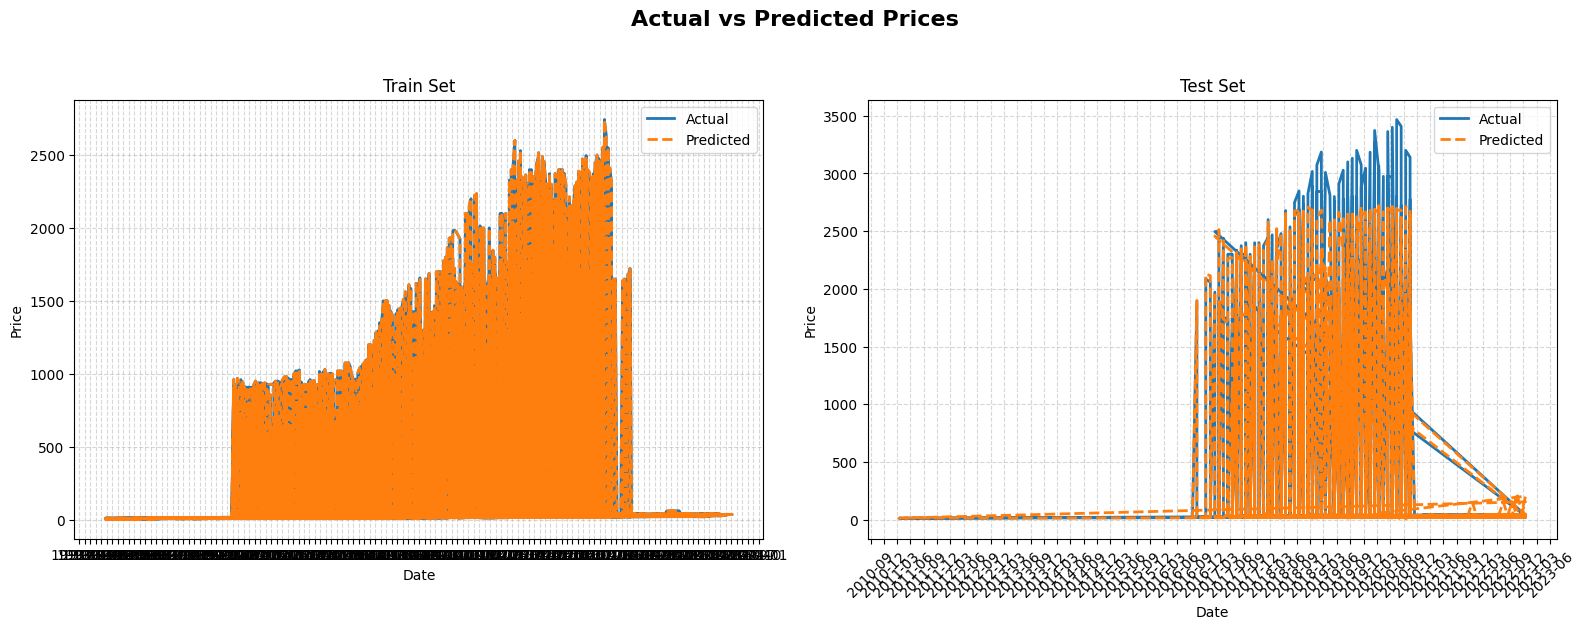

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Plot settings
plt.figure(figsize=(16, 6))
plt.suptitle('Actual vs Predicted Prices', fontsize=16, fontweight='bold')

# === Train Plot ===
plt.subplot(1, 2, 1)
plt.plot(y_train.index, y_train, label='Actual', color='#1f77b4', linewidth=2)
plt.plot(y_train.index, y_train_pred, label='Predicted', color='#ff7f0e', linestyle='--', linewidth=2)
plt.title('Train Set')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# === Test Plot ===
plt.subplot(1, 2, 2)
plt.plot(y_test.index, y_test, label='Actual', color='#1f77b4', linewidth=2)
plt.plot(y_test.index, y_test_pred, label='Predicted', color='#ff7f0e', linestyle='--', linewidth=2)
plt.title('Test Set')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.xticks(rotation=45)
plt.show()


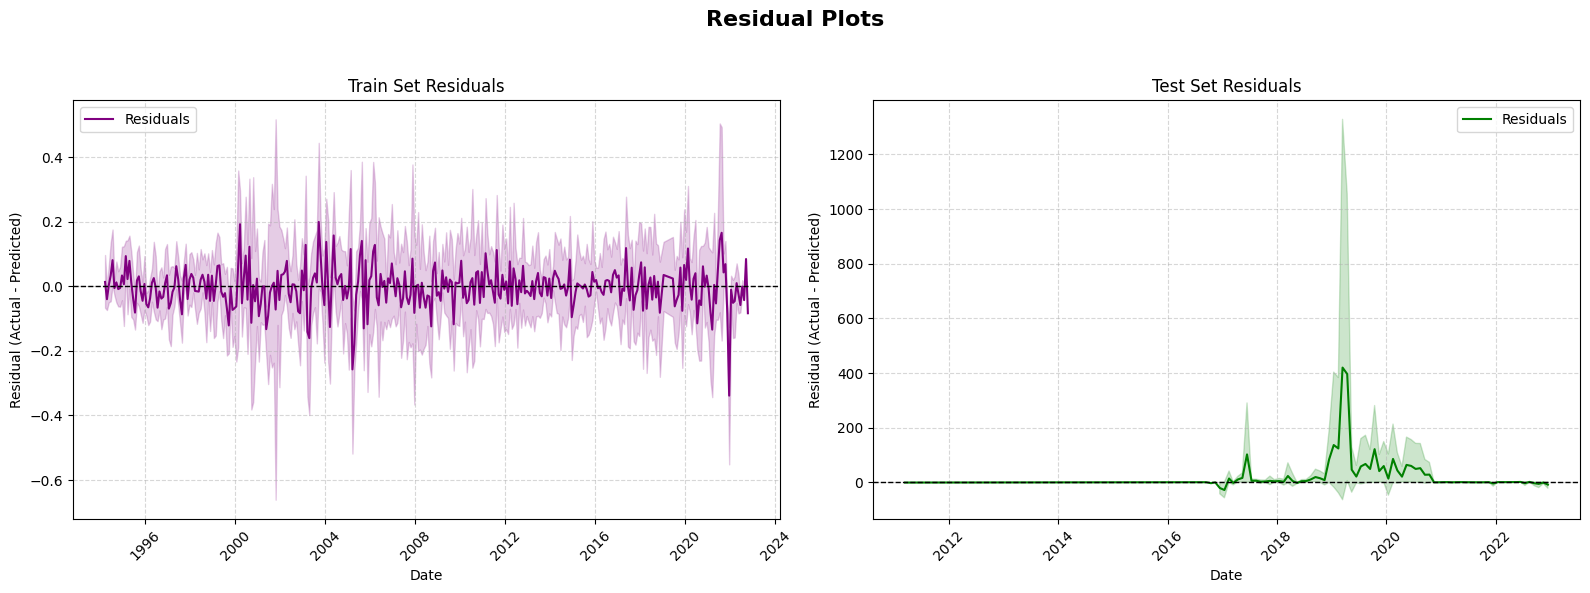

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate residuals
residuals_train = y_train - y_train_pred
residuals_test = y_test - y_test_pred

# Plot residuals
plt.figure(figsize=(16, 6))
plt.suptitle('Residual Plots', fontsize=16, fontweight='bold')

# Train Residuals
plt.subplot(1, 2, 1)
sns.lineplot(x=y_train.index, y=residuals_train, color='purple', label='Residuals')
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.title('Train Set Residuals')
plt.xlabel('Date')
plt.ylabel('Residual (Actual - Predicted)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=45)

# Test Residuals
plt.subplot(1, 2, 2)
sns.lineplot(x=y_test.index, y=residuals_test, color='green', label='Residuals')
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.title('Test Set Residuals')
plt.xlabel('Date')
plt.ylabel('Residual (Actual - Predicted)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=45)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [ ]:
from sklearn.model_selection import cross_val_score
import numpy as np
import xgboost as xgb
from sklearn.metrics import make_scorer, mean_squared_error

# Assuming X_train and y_train are your features and target variable
model = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.1, max_depth=5)

# Use mean_squared_error for scoring
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Perform 5-fold cross-validation
mse_scores = cross_val_score(model, X_train, y_train, cv=5, scoring=mse_scorer)

# Print the MSE scores for each fold
print("Cross-Validation MSE Scores (5-fold):", mse_scores)

# Print the mean of the cross-validation MSE scores
print("Mean Cross-Validation MSE:", np.mean(mse_scores))


Cross-Validation MSE Scores (5-fold): [-4641.84860708 -1078.61563134 -5787.74939709 -2654.40741161
 -2805.45886588]
Mean Cross-Validation MSE: -3393.61598259924


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002280 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4111
[LightGBM] [Info] Number of data points in the train set: 4503, number of used features: 23
[LightGBM] [Info] Start training from score 213.211437
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

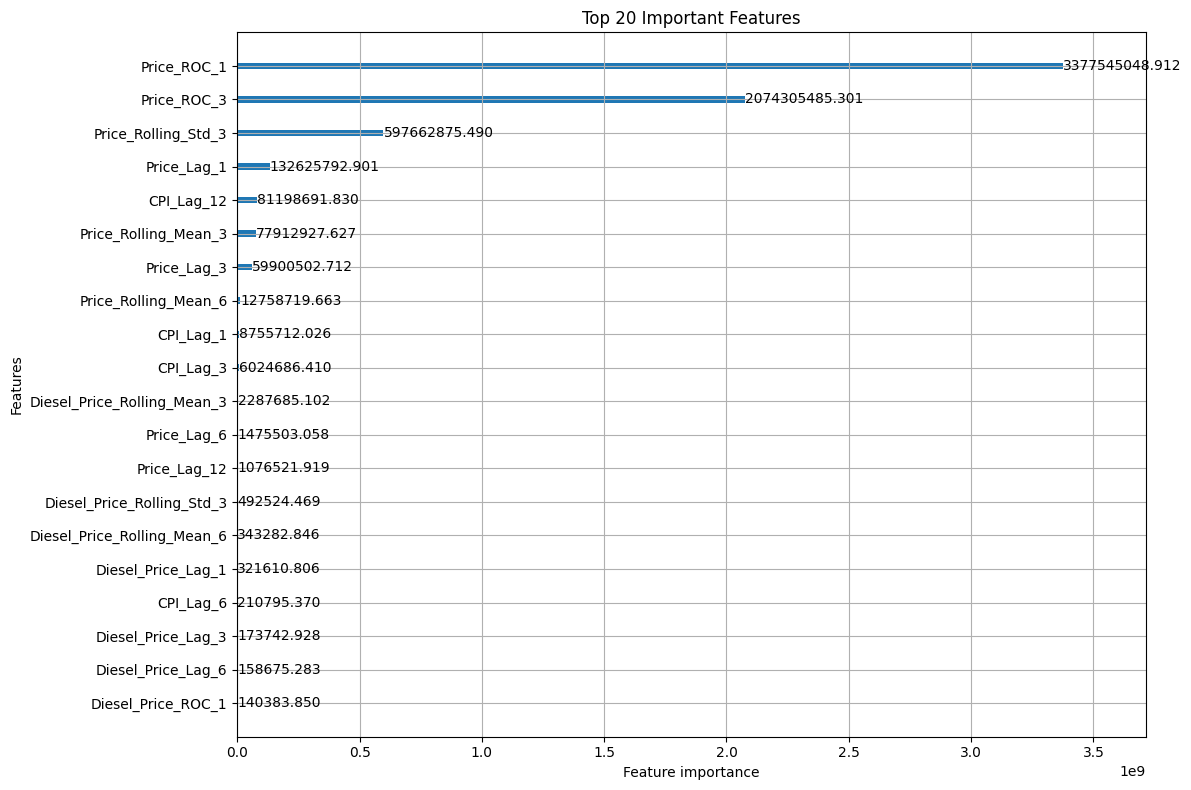

In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

# Step 1: Define X and y
X_train = train_df_encoded[features]
y_train = train_df_encoded['price']
X_test = test_df_encoded[features]
y_test = test_df_encoded['price']

# Step 2: Train LightGBM
lgb_model = lgb.LGBMRegressor(
    n_estimators=500,
    learning_rate=0.1,
    max_depth=4,
    subsample=0.7,
    colsample_bytree=0.7,
    reg_alpha=1.5,
    reg_lambda=1.5,
    random_state=42
)

lgb_model.fit(X_train, y_train)

# Step 3: Predict
y_pred_train = lgb_model.predict(X_train)
y_pred_test = lgb_model.predict(X_test)

# Step 4: Evaluation
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
mae_test = mean_absolute_error(y_test, y_pred_test)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test) * 100

print(f"\n📊 LightGBM Performance Metrics:")
print(f"Train RMSE: {rmse_train:.2f}")
print(f"Test RMSE: {rmse_test:.2f}")
print(f"Test MAE: ₹{mae_test:.2f}")
print(f"Test MAPE: {mape_test:.2f}%")

# Step 5: Diagnostics - Per State Errors
print("\n📍 State-wise MAE and MAPE:")
test_df_encoded = test_df_encoded.copy()
test_df_encoded['y_true'] = y_test
test_df_encoded['y_pred'] = y_pred_test

# Recover state names from one-hot encoding
if 'state' not in test_df_encoded.columns:
    ohe_columns = [col for col in test_df_encoded.columns if col.startswith("state_")]
    test_df_encoded['state'] = test_df_encoded[ohe_columns].idxmax(axis=1).str.replace("state_", "")

for state, group in test_df_encoded.groupby('state'):
    mae = mean_absolute_error(group['y_true'], group['y_pred'])
    mape = mean_absolute_percentage_error(group['y_true'], group['y_pred']) * 100
    print(f"{state:<20} MAE: ₹{mae:.2f} | MAPE: {mape:.2f}%")

# Step 6: Feature Importance Plot
print("\n📈 Feature Importance:")
lgb.plot_importance(lgb_model, max_num_features=20, importance_type='gain')
plt.title("Top 20 Important Features")
plt.tight_layout()
plt.show()


Visualize Actual Vs predicted

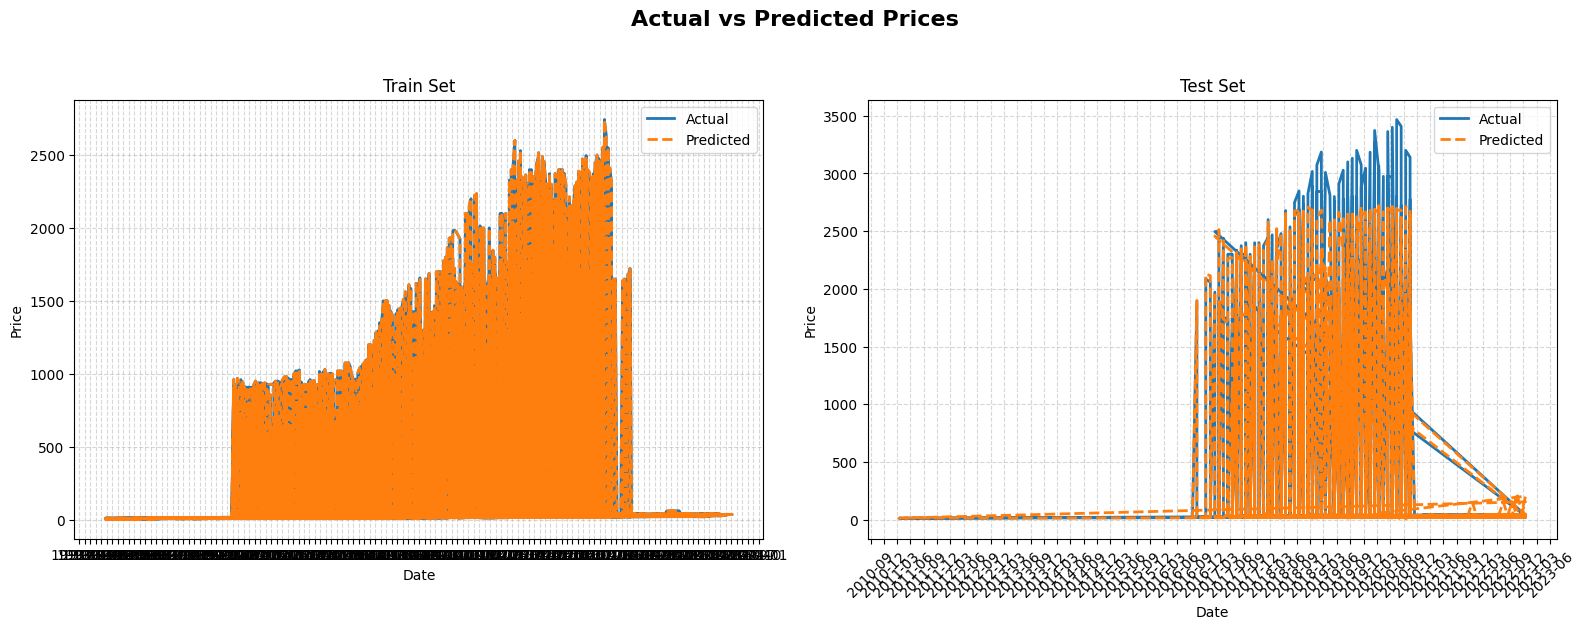

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Plot settings
plt.figure(figsize=(16, 6))
plt.suptitle('Actual vs Predicted Prices', fontsize=16, fontweight='bold')

# === Train Plot ===
plt.subplot(1, 2, 1)
plt.plot(y_train.index, y_train, label='Actual', color='#1f77b4', linewidth=2)
plt.plot(y_train.index, y_train_pred, label='Predicted', color='#ff7f0e', linestyle='--', linewidth=2)
plt.title('Train Set')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# === Test Plot ===
plt.subplot(1, 2, 2)
plt.plot(y_test.index, y_test, label='Actual', color='#1f77b4', linewidth=2)
plt.plot(y_test.index, y_test_pred, label='Predicted', color='#ff7f0e', linestyle='--', linewidth=2)
plt.title('Test Set')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.xticks(rotation=45)
plt.show()


#Residuals

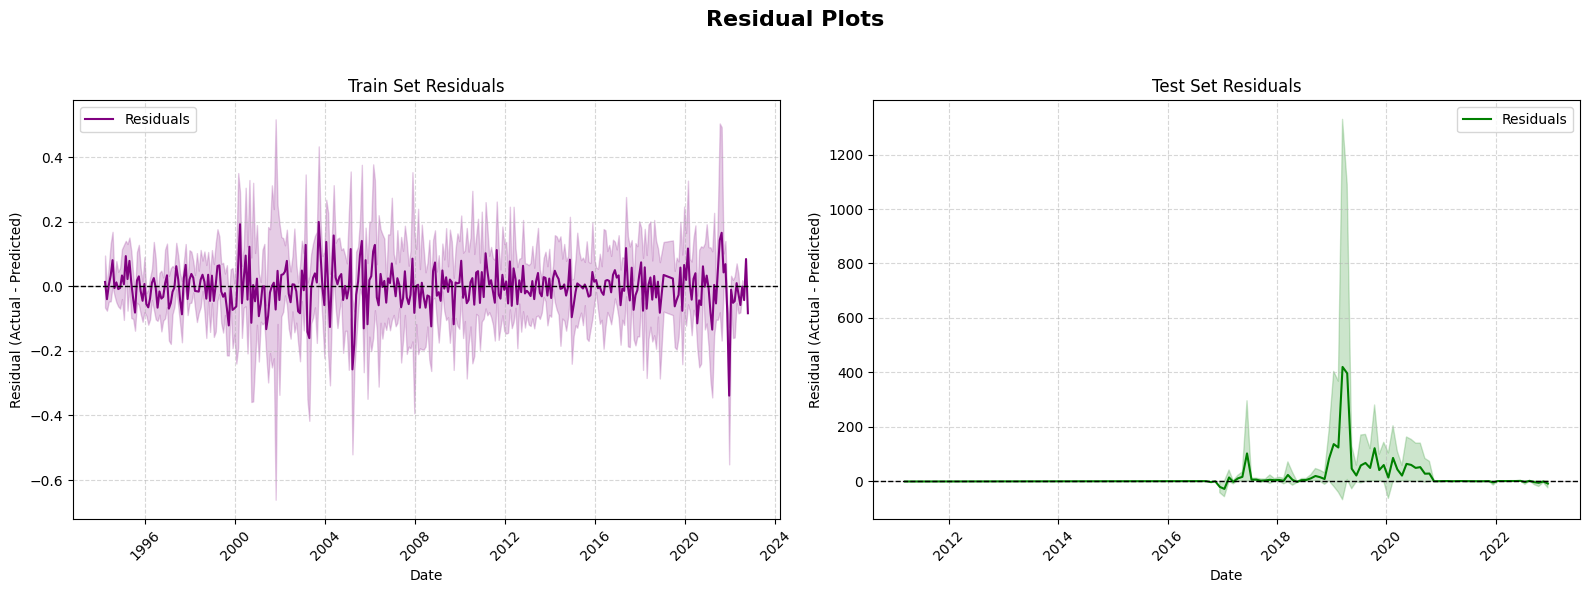

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate residuals
residuals_train = y_train - y_train_pred
residuals_test = y_test - y_test_pred

# Plot residuals
plt.figure(figsize=(16, 6))
plt.suptitle('Residual Plots', fontsize=16, fontweight='bold')

# Train Residuals
plt.subplot(1, 2, 1)
sns.lineplot(x=y_train.index, y=residuals_train, color='purple', label='Residuals')
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.title('Train Set Residuals')
plt.xlabel('Date')
plt.ylabel('Residual (Actual - Predicted)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=45)

# Test Residuals
plt.subplot(1, 2, 2)
sns.lineplot(x=y_test.index, y=residuals_test, color='green', label='Residuals')
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.title('Test Set Residuals')
plt.xlabel('Date')
plt.ylabel('Residual (Actual - Predicted)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=45)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


Model Evaluation:
Mean Absolute Error (MAE): ₹146.74

On average, the model's predictions are off by ₹146.74 for each wheat price. This is the average error the model makes.

Root Mean Squared Error (RMSE): ₹401.78

The RMSE tells us how much the predictions deviate from the actual values, with larger errors penalized more. A higher RMSE indicates a bigger spread of errors.

R² Score: 0.7398

The R² value is quite good at 0.74, meaning 73.98% of the variance in wheat prices can be explained by the model. This is a strong indicator that the model is capturing the key patterns in the data.

Feature Engineering:
Lag Features: Already created lag features, but perhaps additional lag features or rolling mean features might help.

Non-linear Relationships: Can try adding interaction terms or polynomial features (e.g., product of Diesel Price and Rainfall).

Time-based Features: Maybe adding holiday effects, quarterly trends, or seasonal indicators for specific periods might improve the model.

2. Model Tuning:
Hyperparameter Tuning: The learning rate, max depth, number of estimators, etc., could be optimized. You can use GridSearchCV or RandomizedSearchCV for this.

In [ ]:
!pip install linearmodels

### RandomForestRegressor (Ensemble Method)
Random forests are generally good with regression tasks and might perform better than XGBoost on certain datasets, especially when the dataset isn't very large.

Train the model

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Initialize and fit the RandomForest model
rf_model = RandomForestRegressor(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)

# Predict and evaluate
rf_predictions = rf_model.predict(X_test)


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Evaluate the model
mse = mean_squared_error(y_test, rf_predictions)
mae = mean_absolute_error(y_test, rf_predictions)
r2 = r2_score(y_test, rf_predictions)

# Print the evaluation results
print(f"Random Forest Model Evaluation:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")


Random Forest Model Evaluation:
Mean Squared Error (MSE): 19722.3200
Mean Absolute Error (MAE): 23.7638
R² Score: 0.9682


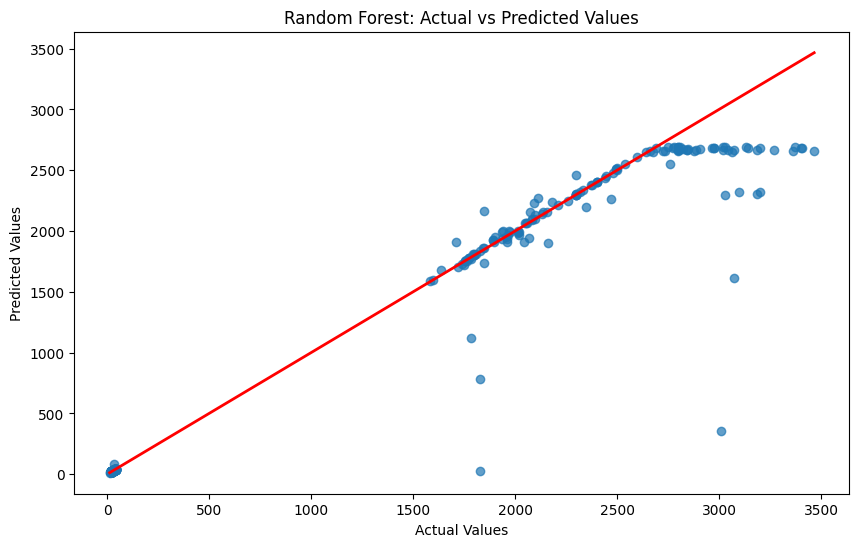

In [ ]:
import matplotlib.pyplot as plt

# Plot Actual vs Predicted values
plt.figure(figsize=(10,6))
plt.scatter(y_test, rf_predictions, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)  # 45-degree line
plt.title("Random Forest: Actual vs Predicted Values")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.show()


Feature Importance:
Useful analysis to see which features the model found important

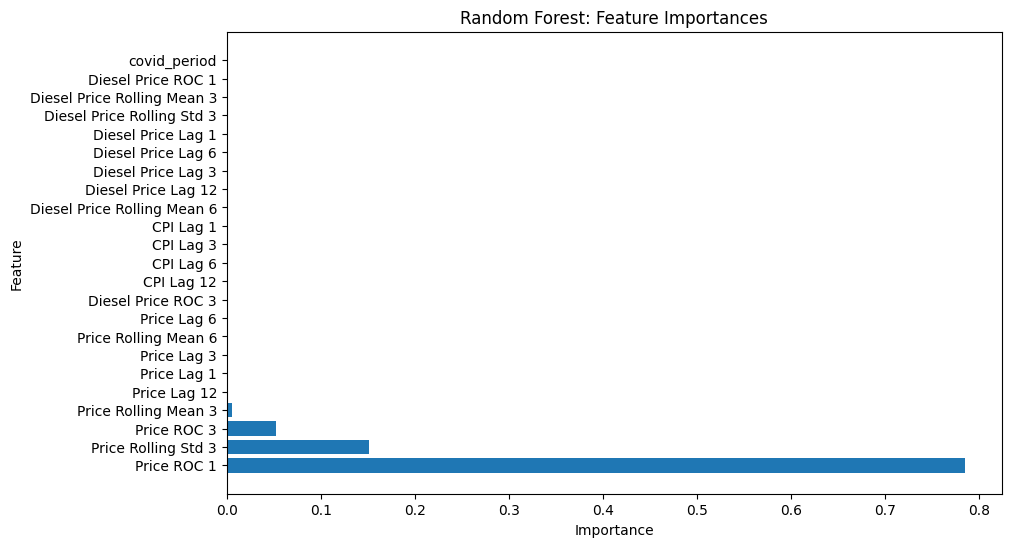

In [ ]:
# Get feature importances
importances = rf_model.feature_importances_

# Sort feature importances in descending order
indices = importances.argsort()[::-1]

# Plot the feature importances
plt.figure(figsize=(10,6))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.title("Random Forest: Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


Validation Performance (Cross-validation)
validate the model further by perform cross-validation. This will give more robust estimate of the model’s performance by averaging the results over multiple splits of the data.

In [ ]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Print the cross-validation results
print(f"Cross-Validation MSE Scores (5-fold): {cv_scores}")
print(f"Mean Cross-Validation MSE: {-cv_scores.mean():.4f}")


Cross-Validation MSE Scores (5-fold): [-5352.36645232 -1530.7374951  -4423.39076126   -70.48983642
 -3855.32097484]
Mean Cross-Validation MSE: 3046.4611


<ipython-input-107-ad4b58cb5629>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['price'] = scaler.fit_transform(df[['price']])
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - loss: 0.1962 - val_loss: 0.1023
Epoch 2/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0629 - val_loss: 0.0770
Epoch 3/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0431 - val_loss: 0.0704
Epoch 4/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0341 - val_loss: 0.0620
Epoch 5/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0274 - val_loss: 0.0611
Epoch 6/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0289 - val_loss: 0.0568
Epoch 7/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0269 - val_loss: 0.0518
Epoch 8/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0250 - val_loss: 0.0510
Epoch 9/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0234 - val_loss: 0.0498
Epoch 10/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0231 - val_loss: 0.0484
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
RMSE: 0.21998963979662273
MAE: ₹0.14
MAPE: 2333.12%


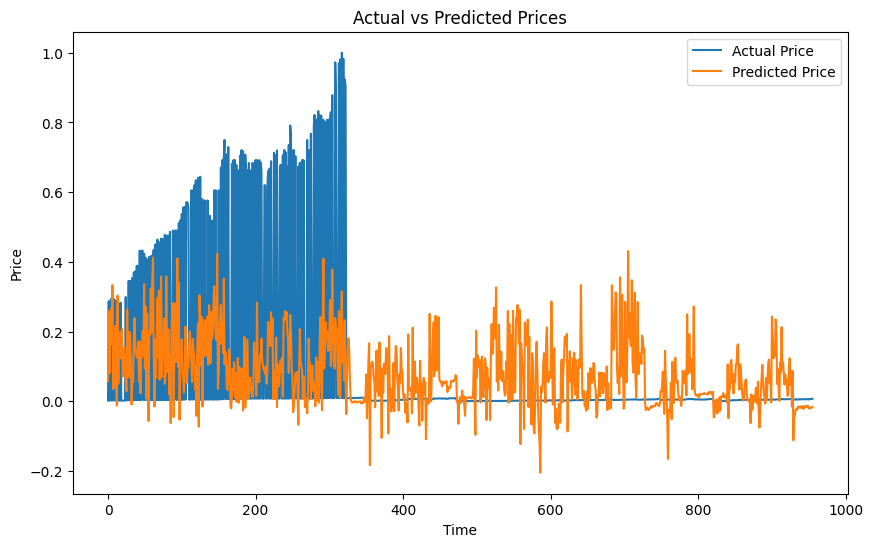

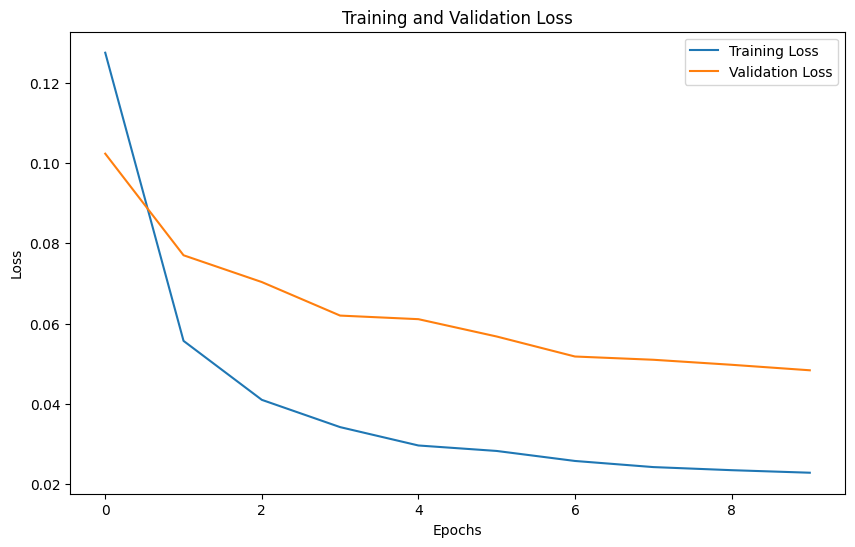

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Scaling the data - Ensure features and target are consistently scaled
scaler = MinMaxScaler()

# Assuming df is your data frame, apply scaling to the price column
df['price'] = scaler.fit_transform(df[['price']])

# Create sequences with multiple features for LSTM
def create_sequences(df, features, target, seq_length=30):
    X, y = [], []
    for state, group in df.groupby('state'):
        group = group.sort_index()  # Sorting by the date index
        X_group = group[features].values  # Use multiple features
        prices = group[target].values
        for i in range(len(group) - seq_length):
            X.append(X_group[i:i + seq_length])
            y.append(prices[i + seq_length])
    return np.array(X), np.array(y)


# Create sequences (X and y) for LSTM
X, y = create_sequences(df, features=features, target='price', seq_length=30)

# Reshape data to fit LSTM input (samples, time_steps, features)
X = X.reshape(X.shape[0], X.shape[1], X.shape[2])

# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Build LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(units=1))  # Output layer with one unit for regression
model.compile(optimizer=Adam(), loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Make predictions
y_pred = model.predict(X_test)

# Inverse scale the predictions and actual values
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate RMSE, MAE, and MAPE
rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
print(f"RMSE: {rmse}")

mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
print(f"MAE: ₹{mae:.2f}")

mape = mean_absolute_percentage_error(y_test_rescaled, y_pred_rescaled) * 100
print(f"MAPE: {mape:.2f}%")

# Plot Actual vs Predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled, label='Actual Price')
plt.plot(y_pred_rescaled, label='Predicted Price')
plt.title('Actual vs Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

# Optionally, you can also plot the training/validation loss history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
